## GPLVM - single cell qPCR Data

This is the translated version of Pyro's example shown below:

https://pyro.ai/examples/gplvm.html

To understand the background of this example, please read Pyro's splendid explanation.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz as az

from toygp import gp, gpx, kernels

In [3]:
jax.config.update('jax_enable_x64', True)

In [4]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

## Load Data

In [5]:
# license: Copyright (c) 2014, the Open Data Science Initiative
# license: https://www.elsevier.com/legal/elsevier-website-terms-and-conditions

URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"
df = pd.read_csv(URL, index_col=0)

In [6]:
print('data shape', df.shape)
print('labels', df.index.unique().to_list())

df.head()

data shape (437, 48)
labels ['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE', '64 EPI']


,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


## Preprocessing

In [7]:
y = df.values
y.shape

(437, 48)

In [8]:
y_mu = y.mean(axis=0)
y_sd = y.std(axis=0)

y_scaled = (y - y_mu) / y_sd

In [9]:
capture_time = np.array([int(cell_name.split(' ')[0]) for cell_name in df.index.values])
time = np.log2(capture_time) / 6

## Define Inducing Vectors

In [10]:
X_mu = jnp.stack([time, jnp.zeros(y.shape[0])], axis=-1)
X_mu.shape

(437, 2)

In [11]:
ndim_latent = 2
num_inducing_pts = 100

Xu = gp.setup_inducing_normal(jax.random.PRNGKey(2), ndim_latent, num_inducing_pts)

## Define Model

In [12]:
def model(y, xu, x_mu, ndim_latent):

    num_data = y.shape[0]
    num_feat = y.shape[1]

    #
    # Sample Latent Variable
    #

    dist_latent = dist.Normal(loc=x_mu, scale=jnp.ones((num_data, ndim_latent)) * 0.1)
    x_latent = numpyro.sample('x_latent', dist_latent)

    #
    # Define Kernel Function
    #

    rho = numpyro.sample('rho', dist.Gamma(2, 1))
    var = numpyro.sample('var', dist.HalfNormal(10))
    kf = lambda x, y : var * kernels.rbf(x, y, rho)

    #
    # Define GP
    #

    Xu = numpyro.param('Xu', xu)
    noise_sd = numpyro.sample('noise_sd', dist.Normal(0, 10))
    jitter = numpyro.sample('jitter', dist.HalfNormal(5))

    W, D = gpx.sparse_vfe(kf, x_latent, Xu, noise_sd, jitter)
    dist_gp = dist.LowRankMultivariateNormal(loc=jnp.zeros(num_data), cov_factor=W, cov_diag=D)

    #
    # Set Observed Data
    #

    with numpyro.plate('feature', size=num_feat):

        numpyro.sample('obs', dist_gp, obs=y.transpose())


## Inference

In [13]:
guide = numpyro.infer.autoguide.AutoNormal(model)

optimizer = numpyro.optim.Adam(step_size=0.01)
svi = numpyro.infer.SVI(model, guide, optimizer, loss=numpyro.infer.Trace_ELBO())

In [14]:
%%time
svi_result = svi.run(jax.random.PRNGKey(0), 10000, y=y_scaled, xu=Xu, x_mu=X_mu, ndim_latent=ndim_latent)

100%|██████████| 10000/10000 [01:11<00:00, 140.63it/s, init loss: 109356.1931, avg. loss [9501-10000]: 19811.2844]


CPU times: user 2min 27s, sys: 4min 5s, total: 6min 32s
Wall time: 1min 15s


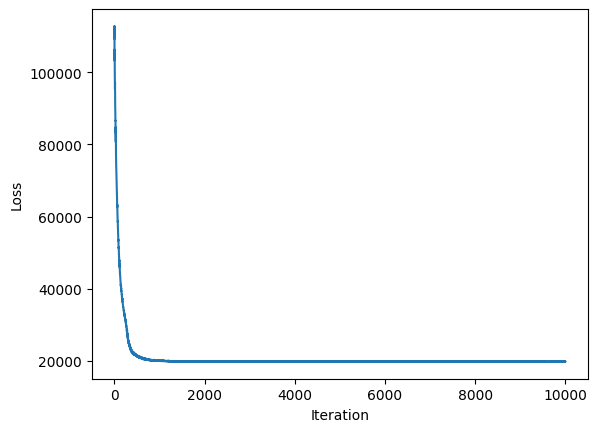

In [15]:
plt.plot(svi_result.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## Check Samples

To use arviz's visualization, posterior samples are generated as (2, 1000) to mimic 2-chain MCMC-samples.

In [16]:
posterior_samples = guide.sample_posterior(jax.random.PRNGKey(2), svi_result.params, (2, 1000))
idata = az.from_dict(posterior_samples)

In [17]:
az.summary(idata, var_names=['rho', 'var', 'jitter'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.102,0.001,0.099,0.105,0.000,0.0,2117.0,1895.0,1.0
var,0.731,0.031,0.669,0.785,0.001,0.0,2059.0,1848.0,1.0
jitter,0.000,0.001,0.000,0.001,0.000,0.0,2119.0,1862.0,1.0


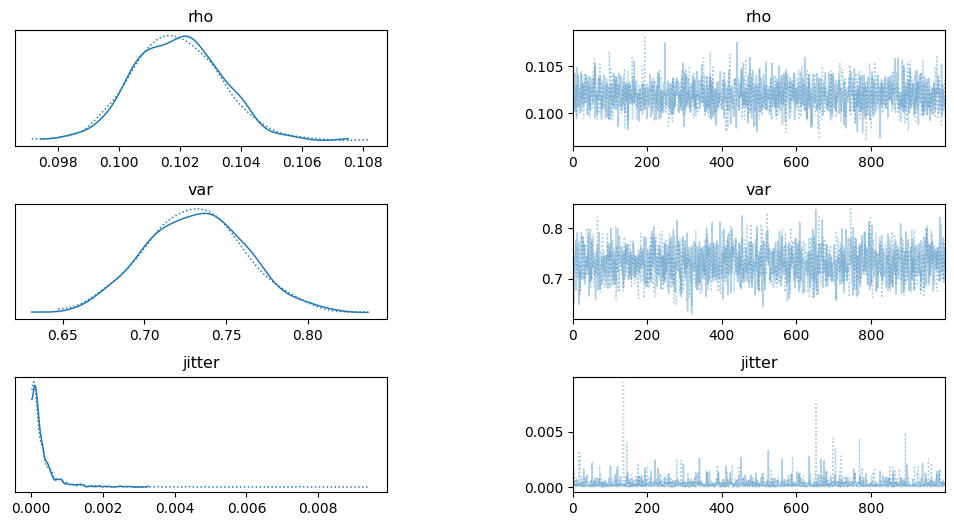

In [18]:
az.plot_trace(idata, var_names=['rho', 'var', 'jitter'])
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Visualize Latent Variables

In [19]:
x_latent = posterior_samples['x_latent'][0, ...]
x_latent = np.mean(x_latent, axis=0)
x_latent.shape

(437, 2)

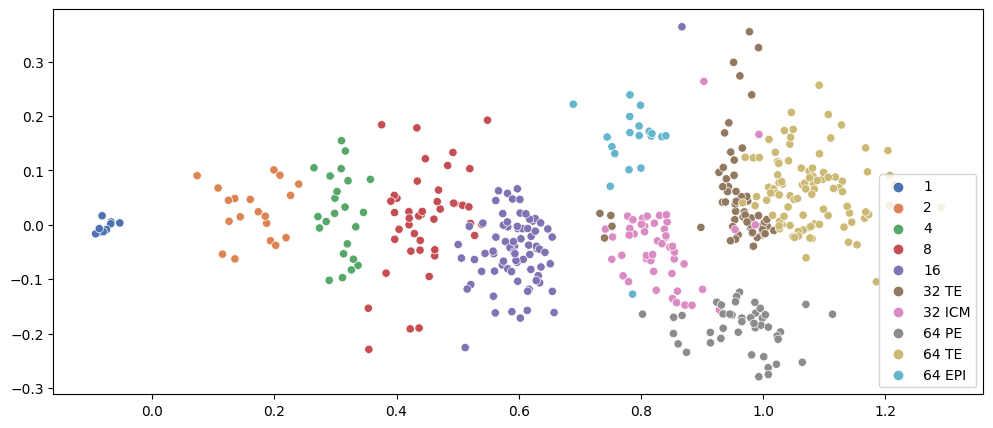

In [20]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=x_latent[:, 0], y=x_latent[:, 1], hue=df.index.values, palette='deep')
plt.show()

## Reference

[1] Resolution of Cell Fate Decisions Revealed by Single-Cell Gene Expression Analysis from Zygote to Blastocyst,     Guoji Guo, Mikael Huss, Guo Qing Tong, Chaoyang Wang, Li Li Sun, Neil D. Clarke, Paul Robson

[2] GrandPrix: Scaling up the Bayesian GPLVM for single-cell data,     Sumon Ahmed, Magnus Rattray, Alexis Boukouvalas

[3] A novel approach for resolving differences in single-cell gene expression patterns from zygote to blastocyst,     Florian Buettner, Fabian J. Theis
